## ARIMA Model Implementation

### Importing Tractor Dataset

In [6]:
import pandas as pd
import numpy as np

In [7]:
data=pd.read_csv("Tractor-Sales.csv")

In [8]:
data.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [9]:
data.tail()

,Month-Year,Number of Tractor Sold
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519
143,Dec-14,605


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Month-Year              144 non-null    object
 1   Number of Tractor Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [11]:
data.shape

(144, 2)

## Data Preprocessing

In [12]:
dates=pd.date_range(start='2003-01-01',freq='MS',periods=len(data))


In [13]:
data["Month"]=dates.month
data.head()

,Month-Year,Number of Tractor Sold,Month
0,Jan-03,141,1
1,Feb-03,157,2
2,Mar-03,185,3
3,Apr-03,199,4
4,May-03,203,5


In [14]:
data["Year"]=dates.year
data.head()

,Month-Year,Number of Tractor Sold,Month,Year
0,Jan-03,141,1,2003
1,Feb-03,157,2,2003
2,Mar-03,185,3,2003
3,Apr-03,199,4,2003
4,May-03,203,5,2003


In [15]:
import calendar
data["Month"]=data["Month"].apply(lambda x: calendar.month_abbr[x])
data.head()

,Month-Year,Number of Tractor Sold,Month,Year
0,Jan-03,141,Jan,2003
1,Feb-03,157,Feb,2003
2,Mar-03,185,Mar,2003
3,Apr-03,199,Apr,2003
4,May-03,203,May,2003


In [16]:
data.drop(["Month-Year"],axis=1,inplace=True)

In [17]:
data.rename(columns={"Number of Tractor Sold":"Sale"},inplace=True)

In [18]:
data.set_index(dates,inplace=True)

In [19]:
data.head()

,Sale,Month,Year
2003-01-01,141,Jan,2003
2003-02-01,157,Feb,2003
2003-03-01,185,Mar,2003
2003-04-01,199,Apr,2003
2003-05-01,203,May,2003


In [20]:
df=data.copy()

In [21]:
df.drop(["Month","Year"],axis=1,inplace=True)

In [22]:
df.head()

,Sale
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203


In [23]:
df = df.rename_axis('Month')
df.head()

,Sale
Month,
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203


In [24]:
from datetime import datetime

## Analysing Stationarity

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline


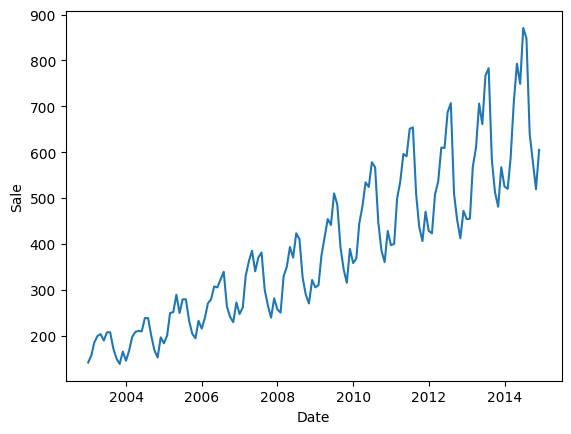

In [26]:
# Plot graph
plt.xlabel("Date")
plt.ylabel("Sale")
plt.plot(df)

In [27]:
df.describe()

,Sale
count,144.000000
mean,389.694444
std,171.500016
min,138.000000
25%,248.500000
50%,369.000000
75%,509.250000
max,871.000000


In [28]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [30]:
test_result=adfuller(df['Sale'])

In [31]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [33]:
adfuller_test(df['Sale'])

ADF Test Statistic : 1.1088250591467326
p-value : 0.9952912415248419
#Lags Used : 14
Number of Observations Used : 129
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Differencing

In [34]:
df['Seasonal First Difference']=df['Sale']-df['Sale'].shift(12)

In [35]:
df.head(14)

,Sale,Seasonal First Difference
Month,,
2003-01-01,141,NaN
2003-02-01,157,NaN
2003-03-01,185,NaN
2003-04-01,199,NaN
2003-05-01,203,NaN
2003-06-01,189,NaN
2003-07-01,207,NaN
2003-08-01,207,NaN
2003-09-01,171,NaN


In [36]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -3.5046148053109882
p-value : 0.007869364043027313
#Lags Used : 1
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

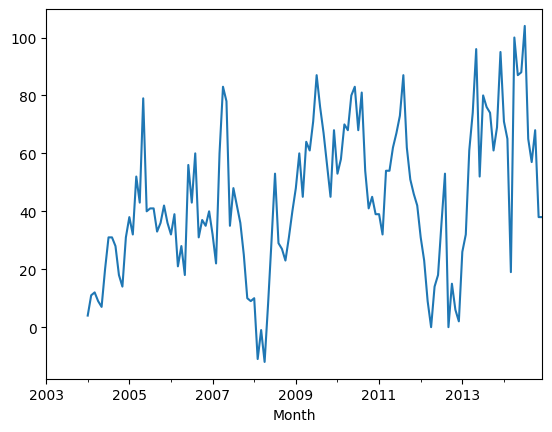

In [37]:
df['Seasonal First Difference'].plot()

## Autocorrelation and Partical Autocorrelation

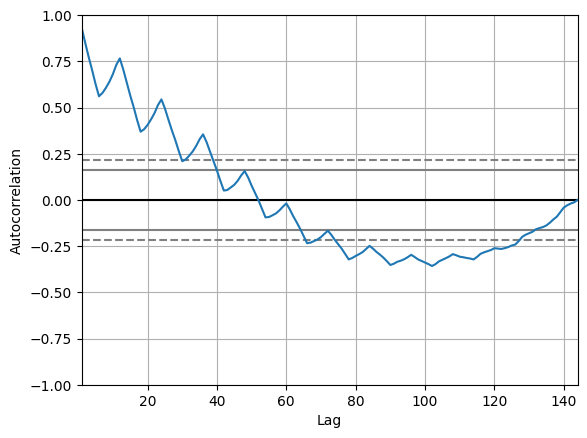

In [39]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sale'])
plt.show()

In [42]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

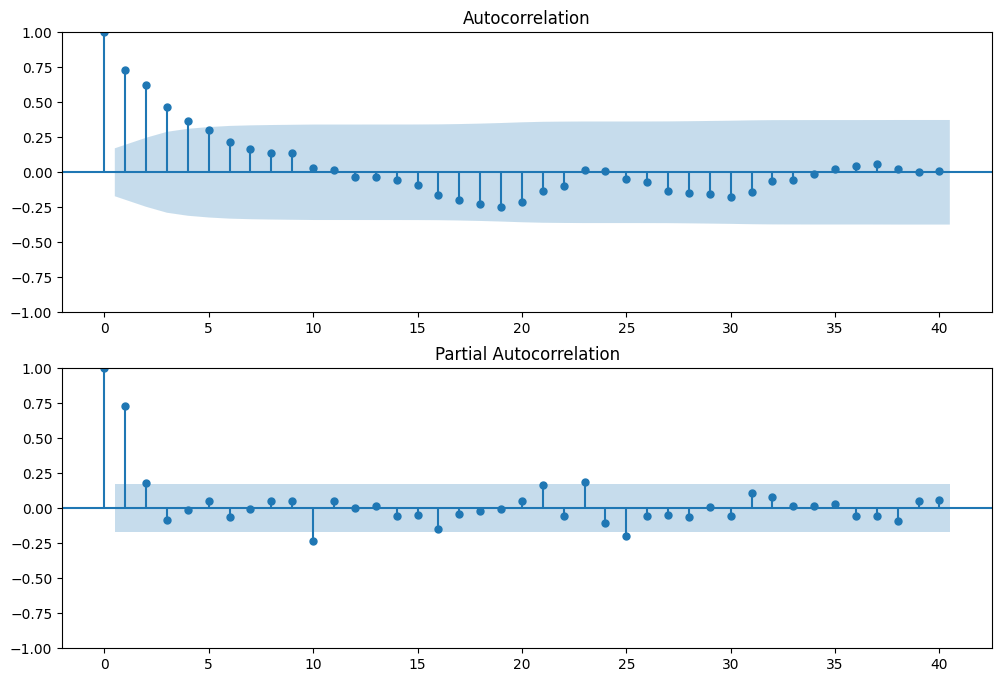

In [43]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

## Implementing ARIMA models

In [47]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [48]:
model=ARIMA(df['Sale'],order=(1,1,1))
model_fit=model.fit()

In [49]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Sale   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -771.639
Date:                Tue, 31 Oct 2023   AIC                           1549.277
Time:                        12:49:33   BIC                           1558.166
Sample:                    01-01-2003   HQIC                          1552.889
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6514      0.075     -8.713      0.000      -0.798      -0.505
ma.L1          0.9439      0.042     22.639      0.000       0.862       1.026
sigma2      2830.6769    314.970      8.987      0.000    2213.347    3448.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.44
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               7.39   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

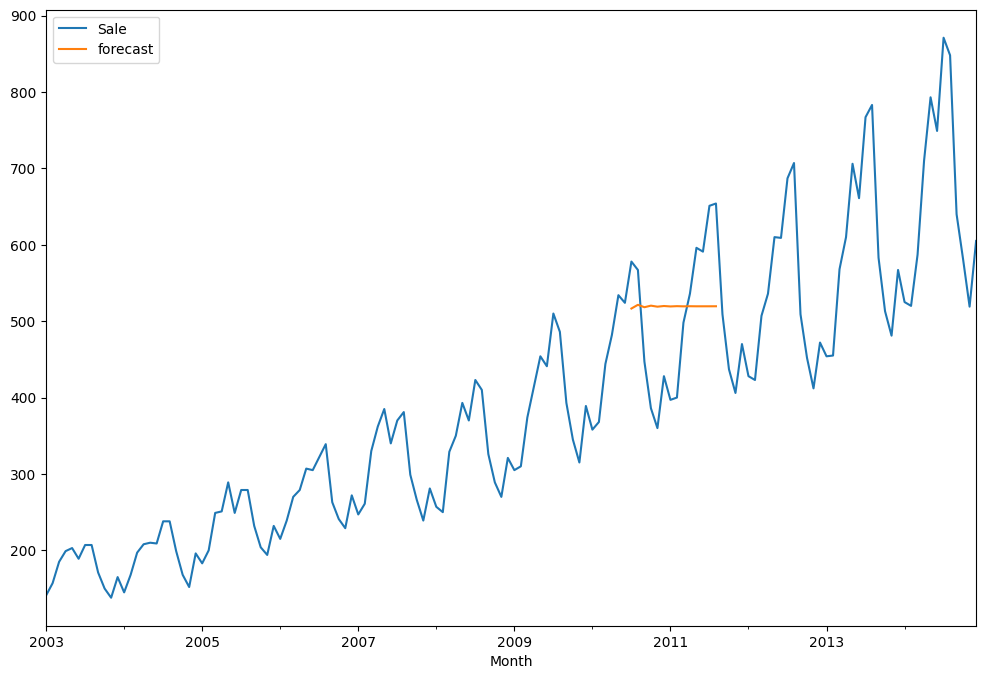

In [51]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Sale','forecast']].plot(figsize=(12,8))

## Implementinmg SARIMA 

In [53]:
model=sm.tsa.statespace.SARIMAX(df['Sale'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

<Axes: xlabel='Month'>

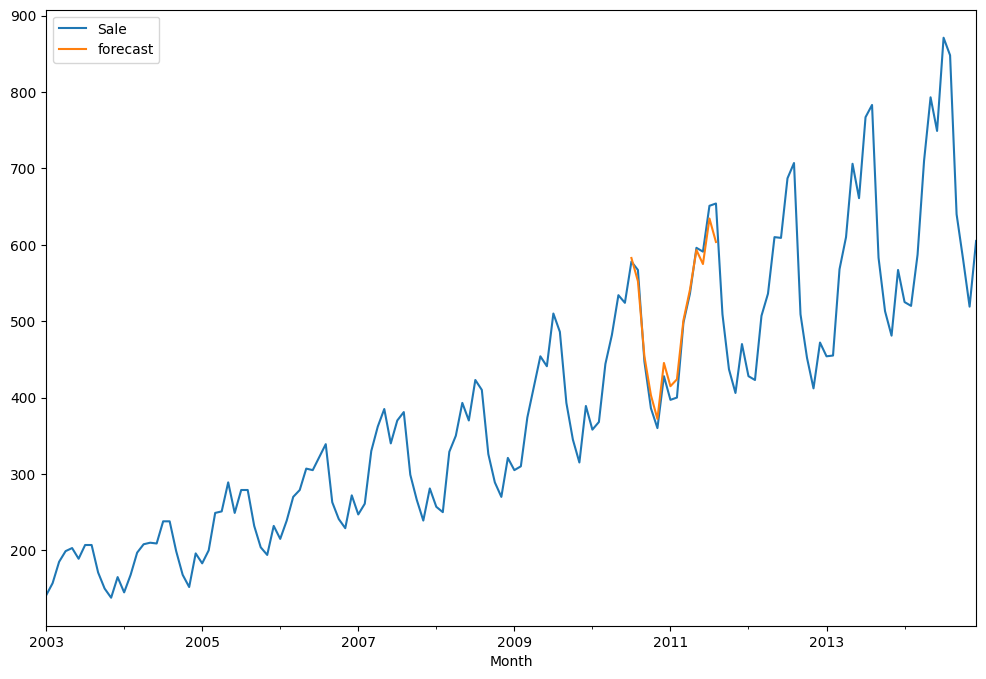

In [55]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sale','forecast']].plot(figsize=(12,8))

## Forecasting

In [80]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [81]:
future_date_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [82]:
future_date_df.tail()

,Sale,Seasonal First Difference,forecast
2016-07-01,NaN,NaN,NaN
2016-08-01,NaN,NaN,NaN
2016-09-01,NaN,NaN,NaN
2016-10-01,NaN,NaN,NaN
2016-11-01,NaN,NaN,NaN


In [83]:
future_df=pd.concat([df,future_date_df])

<Axes: >

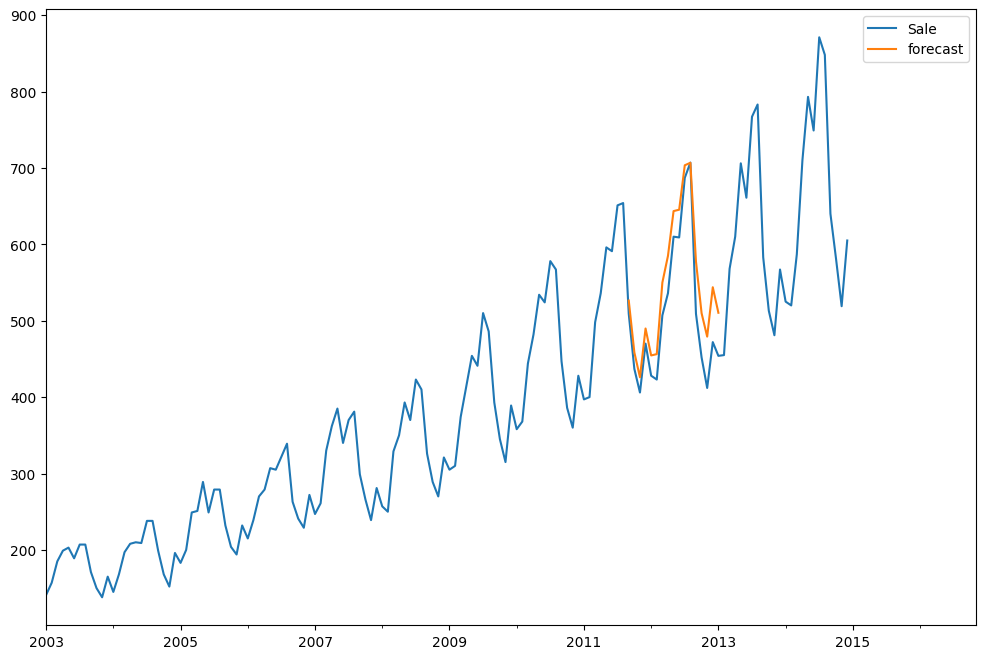

In [84]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sale', 'forecast']].plot(figsize=(12, 8)) 